In [1]:
import os
import sys
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import tqdm
from abc import ABCMeta, abstractmethod, abstractproperty
from copy import copy,deepcopy
from collections import Counter
%matplotlib inline
plt.style.use("ggplot")
%load_ext autoreload
%autoreload 2

## Exercise 5.10 小车race track (Off-policy Mc control)

In [2]:
class Env(metaclass=ABCMeta):
    def __init__(self,rng_seed=random.randint(0,1000)):
        self.rng = np.random.RandomState(rng_seed)
    
    @staticmethod
    def get_actions(self):
        pass
    
    @abstractmethod
    def step(self,action):
        pass
        # return done,observation,reward,extra
        
    @abstractmethod
    def get_observation(self):
        pass
    
    @abstractmethod
    def observation_to_state(self,observation):
        pass
    
    @abstractmethod
    def get_history(self,):
        pass
    
    @abstractmethod
    def get_state_shape(self):
        pass
        
    @abstractmethod
    def reset(self):
        pass
    
class RaceTrackEnv(Env):
    def __init__(self,plane,start_line,end_line,speed_limit=5):
        super().__init__()
        self.plane = plane
        self.start_line = start_line
        self.end_line = end_line
        self.actions = [(i,j) for i in [-1,0,1] for j in [-1,0,1]]
        self.reset()
        self.speed_limit = speed_limit
        self.end_dict = {}
        for one_point in end_line:
            self.end_dict[tuple(one_point)] = 1
        self.w,self.h = plane.shape
        
        self.action2ind = {}
        self.ind2action = {}
        for i,one_action in enumerate(self.actions):
            self.action2ind[one_action] = i
            self.ind2action[i] = one_action
    
    def get_actions(self):
        return self.actions
    
    def is_done(self,old_x,old_y):
        for x in range(min(old_x,old_x + self.speed[0]),max(old_x,old_x + self.speed[0] + 1)):
            if (x,old_y) in self.end_dict:
                return True
        
        for y in range(min(old_y,old_y + self.speed[1]),max(old_y,old_y + self.speed[1] + 1)):
            if (x,y) in self.end_dict:
                return True
        return False
    
    def step(self,action):
        observation_last_step = self.get_observation()
        current_state = self.observation_to_state(observation_last_step)
        alpha_x,alpha_y = action
        self.history.append((copy(current_state),copy(action)))
        
        old_speed_y = self.speed[1]
        old_speed_x = self.speed[0]
        
        self.speed[0] += alpha_x
        if self.speed[0] < -self.speed_limit:self.speed[0] = -self.speed_limit
        elif self.speed[0] > self.speed_limit:self.speed[0] = self.speed_limit
            
        self.speed[1] += alpha_y
        if self.speed[1] < -self.speed_limit:self.speed[1] = -self.speed_limit
        elif self.speed[1] > self.speed_limit:self.speed[1] = self.speed_limit
            
        if self.speed[0] == 0 and self.speed[1] == 0:
            self.speed[1] = old_speed_y
            self.speed[0] = -1
        
        old_x,old_y = self.position
        new_x = old_x + self.speed[0]
        new_y = old_y + self.speed[1]
        
        assert(not(self.speed[0] == 0 and self.speed[1] == 0))
        
        self.position = [new_x,new_y]
        #print(old_x,old_y)
        #print("speed",self.speed)
            
        is_done = self.is_done(old_x,old_y)
        if new_x < 0 or new_x >= self.plane.shape[0] or new_y < 0 or new_y >= self.plane.shape[1]\
            or self.plane[new_x,new_y] < 0:
            #print("returning")
            self.return_to_start()
        if is_done:
            return True,self.get_observation(),1,None
        else:
            return False,self.get_observation(),0,None
        
        
        # return done,observation,reward,extra
        
    def get_observation(self):
        return {
            "plane": self.plane,
            "position": self.position,
            "speed": self.speed,
        }
    
    def observation_to_state(self,observation):
        position = observation["position"]
        speed = observation["speed"]
        speedx,speedy = speed
        assert(speedx >= -self.speed_limit and speedx <= self.speed_limit)
        assert(speedy >= -self.speed_limit and speedy <= self.speed_limit)
        return list(position) + [speedx + self.speed_limit,speedy + self.speed_limit]
    
    def get_history(self):
        return history
    
    def get_state_shape(self):
        return list(self.plane.shape) + [self.speed_limit * 2 + 1,self.speed_limit * 2 + 1]
    
    def return_to_start(self):
        self.position = self.start_line[self.rng.randint(0,len(self.start_line))]
        self.position = copy(self.position)
        self.speed = [0,0]
        
    def reset(self):
        self.return_to_start()
        self.history = []
        

In [3]:
class RaceTrackGenerator(object):
    def __init__(self,width=32,height=32):
        self.width = width
        self.height = height
        
    def generate(self):
        self.plane = -np.ones([self.width,self.height])
        self.plane[:,:9] = 0
        self.plane[:6,:20] = 0
        start_points = []
        end_points = []
        for i in range(9):
            start_points.append([self.width - 1,i])
            
        for i in range(6):
            end_points.append([i,19])
            
        self.start_points = start_points
        self.end_points = end_points
        
        for one_point in start_points:
            self.plane[one_point[0],one_point[1]] = 1
            
        for one_point in end_points:
            self.plane[one_point[0],one_point[1]] = 2
        

In [4]:
raceTrackGenerator = RaceTrackGenerator()

In [5]:
raceTrackGenerator.generate()

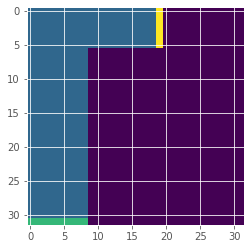

In [6]:
plt.imshow(raceTrackGenerator.plane)

In [7]:
raceTrackEnv = RaceTrackEnv(
    raceTrackGenerator.plane,
    raceTrackGenerator.start_points,
    raceTrackGenerator.end_points)

In [8]:
raceTrackEnv.reset()
while True:
    actions = random.choice(raceTrackEnv.get_actions())
    done,observation,reward,extra = raceTrackEnv.step(actions)
    if done:
        break

In [9]:
len(raceTrackEnv.history)

3350

In [10]:
for one_step in raceTrackEnv.history[-30:]:
    print(one_step)

([17, 1, 2, 6], (-1, 0))
([13, 2, 1, 6], (1, -1))
([10, 2, 2, 5], (0, -1))
([7, 1, 2, 4], (-1, -1))
([31, 6, 5, 5], (-1, 0))
([30, 6, 4, 5], (0, 1))
([29, 7, 4, 6], (1, -1))
([28, 8, 4, 6], (-1, -1))
([26, 8, 3, 5], (1, 1))
([31, 6, 5, 5], (0, 0))
([30, 6, 4, 5], (0, 0))
([29, 6, 4, 5], (1, 0))
([28, 6, 4, 5], (-1, 0))
([26, 6, 3, 5], (0, 0))
([24, 6, 3, 5], (0, 0))
([22, 6, 3, 5], (0, 0))
([20, 6, 3, 5], (0, -1))
([18, 5, 3, 4], (-1, -1))
([15, 3, 2, 3], (1, 1))
([13, 2, 3, 4], (0, 1))
([11, 2, 3, 5], (1, -1))
([10, 1, 4, 4], (-1, 1))
([8, 1, 3, 5], (0, 0))
([6, 1, 3, 5], (1, 1))
([5, 2, 4, 6], (0, 1))
([4, 4, 4, 7], (0, 0))
([3, 6, 4, 7], (0, 1))
([2, 9, 4, 8], (1, 1))
([2, 13, 5, 9], (1, 0))
([3, 17, 6, 9], (-1, 0))


### off policy 环境

In [11]:
class Strategy(metaclass=ABCMeta):
    def __init__(self,env:Env):
        self.env = env
    
    @staticmethod
    def action_probs(self):
        pass
    
class EqualProbStrategy(Strategy):
    def __init__(self,env:Env):
        self.env = env
        self.actions = self.env.get_actions()
    
    def action_probs(self):
        retval = {}
        for one_action in self.actions:
            retval[one_action] = 1.0 / len(self.actions)
        return retval
    
class TargetStrategy(Strategy):
    def __init__(self,env:Env):
        self.env = env
        self.actions = self.env.get_actions()
        self.best_strategy = np.zeros(self.env.get_state_shape())
    
    def action_probs(self):
        state = self.env.observation_to_state(self.env.get_observation())
        
        action_to_select = self.best_strategy[tuple(state)]
        
        retval = {}
        action_sum = 0
        for action_ind,one_action in enumerate(self.actions):
            if action_ind == action_to_select:
                retval[one_action] = 1
                action_sum += 1
            else:
                retval[one_action] = 0
                action_sum += 0
        assert(action_sum == 1)
        return retval
    
    def set_best_strategy(self,state,action):
        self.best_strategy[tuple(state)] = self.env.action2ind[action]

In [12]:
class OffPolicyMcControl(metaclass=ABCMeta):
    def __init__(self,env:Env,target_strategy:Strategy,behavior_strategy:Strategy):
        self.env = env
        self.target_strategy = target_strategy
        self.behavior_strategy = behavior_strategy
    
    @abstractmethod
    def set_env_random_initial_state(self):
        pass
    
    @abstractmethod
    def estimate_value(self,steps):
        pass

class RaceCarOptimizer(OffPolicyMcControl):
    def __init__(self,env:RaceTrackEnv,target_strategy:Strategy,behavior_strategy:Strategy,
                 discount=0.9):
        super().__init__(env,target_strategy,behavior_strategy)
        self.QAshape = self.env.get_state_shape() + [len(self.env.get_actions())]
        self.discount = discount
        self.actions = self.env.actions
        
        self.Q = np.zeros(self.QAshape,dtype=np.float)
        self.C = np.zeros(self.QAshape,dtype=np.float)
        
    def set_env_random_initial_state(self):
        self.env.reset()
        
    def backprog(self,infos):
        (states,rewards,actions,prob_pis,prob_bes) = infos
        G = 0.0
        W = 1.0
        
        for one_state,one_reward,one_action,one_prob_pi,one_prob_be in zip(states[::-1],rewards[::-1],actions[::-1],prob_pis[::-1],prob_bes[::-1]):
            G = G * self.discount + one_reward
            
            one_action_ind = self.env.action2ind[one_action]
            state_action = tuple(one_state + [one_action_ind])
            self.C[state_action] += W
            self.Q[state_action] += (W / self.C[state_action]) * (G - self.Q[state_action])
            
            # TODO 此处仅考虑了reward为正数的情况
            
            best_action_ind = np.argmax(self.Q[tuple(one_state)])
            self.target_strategy.set_best_strategy(one_state,self.actions[best_action_ind])
            
            if one_action_ind == best_action_ind:
                W = W / one_prob_be
            else:
                break
        
    def monte_carlo_run(self):
        self.set_env_random_initial_state()
        states = []
        actions = []
        rewards = []
        
        prob_pis = []
        prob_bes = []
        while True:
            state = self.env.observation_to_state(self.env.get_observation())
            states.append(state)

            nextBehaviorProbs = self.behavior_strategy.action_probs()
            nextTargetProbs = self.target_strategy.action_probs()
            
            nextactions = list(nextBehaviorProbs.keys())
            nextstep = np.random.choice(list(range(len(nextactions))),p=list(nextBehaviorProbs.values()))
            nextstep = nextactions[nextstep]
            
            prob_bes.append(nextBehaviorProbs[nextstep])
            prob_pis.append(nextTargetProbs[nextstep])
            
            done,observation,reward,extra = self.env.step(nextstep)
            actions.append(nextstep)
            rewards.append(reward)
            if done:
                break
        
        self.backprog((states,rewards,actions,prob_pis,prob_bes))
        
    def estimate_value(self,steps):
        for one_step in tqdm.tqdm(range(steps)):
            self.monte_carlo_run()
        

### Off policy Monte Carol Control

In [13]:
raceTrackGenerator = RaceTrackGenerator()
raceTrackGenerator.generate()

raceTrackEnv = RaceTrackEnv(
    raceTrackGenerator.plane,
    raceTrackGenerator.start_points,
    raceTrackGenerator.end_points)

behaviorStrategy = EqualProbStrategy(raceTrackEnv)
targetStrategy = TargetStrategy(raceTrackEnv)

raceCarOptimizer = RaceCarOptimizer(raceTrackEnv,targetStrategy,behaviorStrategy)

In [14]:
raceCarOptimizer.estimate_value(1000)

100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


#### 可视化下这玩意

In [15]:
def generate_one_racetrack():
    raceTrackEnv.reset()
    while True:
        state = raceTrackEnv.observation_to_state(raceTrackEnv.get_observation())

        nextTargetProbs = targetStrategy.action_probs()

        nextactions = list(nextTargetProbs.keys())
        nextstep = np.random.choice(list(range(len(nextactions))),p=list(nextTargetProbs.values()))
        nextstep = nextactions[nextstep]

        done,observation,reward,extra = raceTrackEnv.step(nextstep)
        if done:
            break
            
    paintplane = raceTrackGenerator.plane.copy()
    for one_state,one_action in raceTrackEnv.history:
        paintplane[tuple(one_state[:2])] = 3

    return paintplane

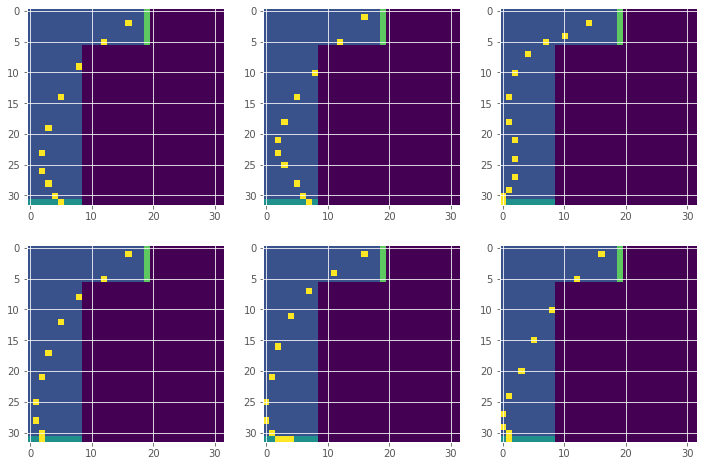

In [16]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i + 1)
    plt.imshow(generate_one_racetrack())

可以发现off policy MC control可以很好的handle这种简单的赛车游戏，但是在更复杂的游戏里，这种简单的Mc control 几乎可以确定无法适用，原因如下：

- 在Mc control中我们使用了一个random behavoir policy，这种random behavior policy在复杂的游戏中有可能几乎没法拿到reward（比如在超级玛丽，通关才算reward的时候）

- 在off policy MC control back prob的时候，又一个很严苛的条件 if one_action_ind ！= best_action_ind: break，这说明如果behavior policy不能产生最佳招法，其产生的track 就无法被学习到

这些条件会使得学习非常困难。